In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pywr.uncertainties.uncertainty import uncertainty
from pywr.uncertainties.format import rounded_uncertainty_with_nominal_value, rounded_uncertainty_with_nominal_value_legacy
from pywr.uncertainties.devices import BRYMEN_BM811_RESISTANCE, BRYMEN_BM857A_RESISTANCE


In [2]:
DATA_PATH = "data/measurements.csv"

In [3]:
def linear_regression_rundown(model: sm.OLS) -> pd.DataFrame:
    a, ua = rounded_uncertainty_with_nominal_value(model.params[1], model.bse[1])
    b, ub = rounded_uncertainty_with_nominal_value(model.params[0], model.bse[0])
    return pd.DataFrame(
        {
            "a": [a],
            "u(a)": [ua],
            "b": [b],
            "u(b)": [ub],
            "R^2": [model.rsquared],
        }
    )

def compute_uncertainties(df: pd.DataFrame) -> pd.DataFrame:
    df["u(R1)"] = df["R1"].apply(
        lambda u: uncertainty(abs(u), 1, BRYMEN_BM811_RESISTANCE)
    )
    df["u(R2)"] = df["R2"].apply(
        lambda i: uncertainty(abs(i), 1, BRYMEN_BM811_RESISTANCE)
    )
    df["u(R3)"] = df["R3"].apply(
        lambda i: uncertainty(abs(i), 1, BRYMEN_BM857A_RESISTANCE)
    )
    df["u(RT)"] = df["RT"].apply(
        lambda i: uncertainty(abs(i), 1, BRYMEN_BM857A_RESISTANCE)
    )

    df["ln(R1)"] = df["R1"].apply(lambda i: np.log(i) if i > 0 else 0)
    df["ln(R2)"] = df["R2"].apply(lambda i: np.log(i) if i > 0 else 0)
    df["ln(R3)"] = df["R3"].apply(lambda i: np.log(i) if i > 0 else 0)
    df["ln(RT)"] = df["RT"].apply(lambda i: np.log(i) if i > 0 else 0)

    df["u(ln(R1))"] = [ur / r if r > 0 else 0 for r, ur in zip(df["R1"], df["u(R1)"])]
    df["u(ln(R2))"] = [ur / r if r > 0 else 0 for r, ur in zip(df["R2"], df["u(R2)"])]
    df["u(ln(R3))"] = [ur / r if r > 0 else 0 for r, ur in zip(df["R3"], df["u(R3)"])]
    df["u(ln(RT))"] = [ur / r if r > 0 else 0 for r, ur in zip(df["RT"], df["u(RT)"])]

    df["T"] = df["RT"].apply(lambda t: 0.243 * float(t) + 28.55)
    df["u(T)"] = df["u(RT)"].apply(lambda t: 0.243 * float(t))

    df["T_inv"] = df["T"].apply(lambda t: 1 / t)
    df["u(T_inv)"] = [ut / t ** 2 for t, ut in zip(df["T"], df["u(T)"])]

    df = df.reindex(columns=["R1", "u(R1)", "R2", "u(R2)", "R3", "u(R3)", "RT", "u(RT)", "ln(R1)", "u(ln(R1))", "ln(R2)", "u(ln(R2))", "ln(R3)", "u(ln(R3))", "ln(RT)", "u(ln(RT))", "T", "u(T)", "T_inv", "u(T_inv)"])
    return df

In [4]:
df = pd.read_csv(DATA_PATH)
df = compute_uncertainties(df)
df["u(R1)"] = df["u(R1)"].apply(lambda u: round(u, 2))
df["u(R2)"] = df["u(R2)"].apply(lambda u: round(u, 2))
# df["u(R3)"] = df["u(R3)"].apply(lambda u: round(u, 2))
# df["u(RT)"] = df["u(RT)"].apply(lambda u: round(u, 2))
display(df.head())

,R1,u(R1),R2,u(R2),R3,u(R3),RT,u(RT),ln(R1),u(ln(R1)),ln(R2),u(ln(R2)),ln(R3),u(ln(R3)),ln(RT),u(ln(RT)),T,u(T),T_inv,u(T_inv)
0,46.26,0.04,43.19,0.04,98.80,0.117549,1079.0,0.624693,3.834278,0.000827,3.765609,0.000845,4.593098,0.001190,6.983790,0.000579,290.7470,0.151800,0.003439,0.000002
1,-1.00,0.01,-1.00,0.01,20.34,0.013475,209.0,0.244797,0.000000,0.000000,0.000000,0.000000,3.012589,0.000663,5.342334,0.001171,79.3370,0.059486,0.012604,0.000009
2,-1.00,0.01,-1.00,0.01,22.82,0.014907,229.0,0.267891,0.000000,0.000000,0.000000,0.000000,3.127637,0.000653,5.433722,0.001170,84.1970,0.065097,0.011877,0.000009
3,-1.00,0.01,-1.00,0.01,24.87,0.016091,249.1,0.291100,0.000000,0.000000,0.000000,0.000000,3.213662,0.000647,5.517854,0.001169,89.0813,0.070737,0.011226,0.000009
4,-1.00,0.01,-1.00,0.01,26.70,0.017147,269.0,0.314079,0.000000,0.000000,0.000000,0.000000,3.284664,0.000642,5.594711,0.001168,93.9170,0.076321,0.010648,0.000009


,a,u(a),b,u(b),R^2
0,0.3485,0.0057,-2.6,1.6,0.999186


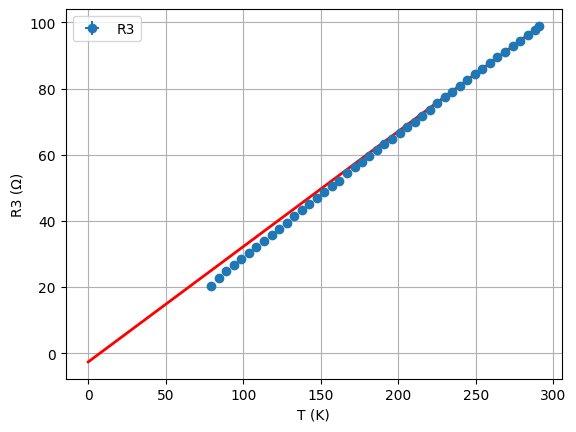

In [5]:
def plot_r3(df: pd.DataFrame):
    x, y = df["T"], df["R3"]
    fig, ax = plt.subplots()
    ax.errorbar(
        x,y,
        xerr=df["u(R3)"],
        yerr=df["u(T)"],
        fmt="o",
        label="R3",
    )
    ax.set_xlabel("T (K)")
    ax.set_ylabel("R3 (Ω)")
    ax.legend()

    xr, yr = sorted(x)[-5:], sorted(y)[-5:]
    model = sm.OLS(yr, sm.add_constant(xr)).fit()
    display(linear_regression_rundown(model))
    X_pred = np.linspace(0, max(x), 10)
    X_pred2 = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred2)
    ax.plot(X_pred, y_pred, "r-", linewidth=2)
    plt.grid()

plot_r3(df)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


,a,u(a),b,u(b),R^2
0,2252,22,-1.27,0.17,0.999706


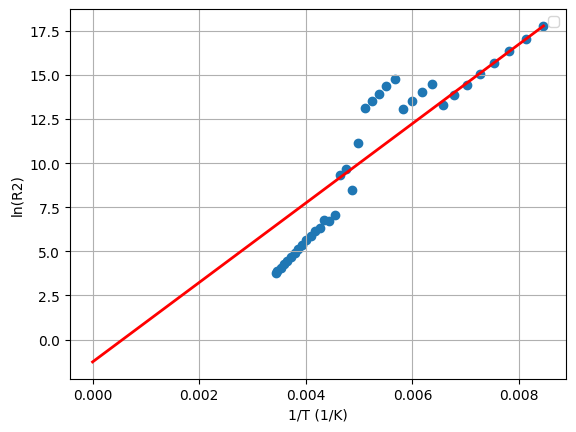

In [6]:
def plot_ln_wrapper(df: pd.DataFrame, r: str):
    x, y = [], []
    for t_inv, ln_r in zip(df["T_inv"], df[f"ln({r})"]):
        if ln_r > 0:
            x.append(t_inv)
            y.append(ln_r)
    fig, ax = plt.subplots()
    ax.scatter(
        x,y,
    )
    ax.set_xlabel("1/T (1/K)")
    ax.set_ylabel(f"ln({r})")
    ax.legend()
    plt.grid()

    xr, yr = sorted(x)[-5:], sorted(y)[-5:]
    model = sm.OLS(yr, sm.add_constant(xr)).fit()
    display(linear_regression_rundown(model))
    X_pred = np.linspace(0, max(x), 10)
    X_pred2 = sm.add_constant(X_pred)
    y_pred = model.predict(X_pred2)
    plt.plot(X_pred, y_pred, "r-", linewidth=2)


# plot_ln_wrapper(df, "R1")
plot_ln_wrapper(df, "R2")

In [11]:
import subprocess

TEMP_HEADER_LATEX = r"$T$ (K)"
UNCERTAINTY_TEMP_HEADER_LATEX = r"$u(T)$ (K)"
TEMP_INV_HEADER_LATEX = r"$1/T$ (10^{6}/K)"
UNCERTAINTY_TEMP_INV_HEADER_LATEX = r"$u(10^{6}/T)$ (1/K)"
RT_HEADER_LATEX = r"$R_T$ (Ω)"
UNCERTAINTY_RT_HEADER_LATEX = r"$u(R_T)$ (Ω)"
R3_HEADER_LATEX = r"$R_3$ (Ω)"
UNCERTAINTY_R3_HEADER_LATEX = r"$u(R_3)$ (Ω)"
LN_RT_HEADER_LATEX = r"$\ln(R_T)$"
UNCERTAINTY_LN_RT_HEADER_LATEX = r"$u(\ln(R_T))$"
LN_R3_HEADER_LATEX = r"$\ln(R_3)$"
UNCERTAINTY_LN_R3_HEADER_LATEX = r"$u(\ln(R_3))$"


def formatted_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    T | u(T) | 1/T | u(1/T) | Rt | u(Rt) | R3 | u(R3)
    """

    formatted_temp_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(t, ut) for t, ut in zip(df["T"], df["u(T)"])]
    formatted_temp_inv_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(t_inv, ut_inv) for t_inv, ut_inv in zip(df["T_inv"].apply(lambda t: t * 1_000_000), df["u(T_inv)"].apply(lambda ut: ut * 1_000_000))]
    formatted_rt_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(rt, urt) for rt, urt in zip(df["RT"], df["u(RT)"])]
    formatted_r3_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(r3, ur3) for r3, ur3 in zip(df["R3"], df["u(R3)"])]

    df_out = pd.DataFrame()

    df_out[TEMP_HEADER_LATEX], df_out[UNCERTAINTY_TEMP_HEADER_LATEX] = [t for t, _ in formatted_temp_with_uncertainties], [ut for _, ut in formatted_temp_with_uncertainties]
    df_out[TEMP_INV_HEADER_LATEX], df_out[UNCERTAINTY_TEMP_INV_HEADER_LATEX] = [t_inv for t_inv, _ in formatted_temp_inv_with_uncertainties], [ut_inv for _, ut_inv in formatted_temp_inv_with_uncertainties]
    df_out[RT_HEADER_LATEX], df_out[UNCERTAINTY_RT_HEADER_LATEX] = [rt for rt, _ in formatted_rt_with_uncertainties], [urt for _, urt in formatted_rt_with_uncertainties]
    df_out[R3_HEADER_LATEX], df_out[UNCERTAINTY_R3_HEADER_LATEX] = [r3 for r3, _ in formatted_r3_with_uncertainties], [ur3 for _, ur3 in formatted_r3_with_uncertainties]

    df_out = df_out.reindex(columns=[
        TEMP_HEADER_LATEX,
        UNCERTAINTY_TEMP_HEADER_LATEX,
        TEMP_INV_HEADER_LATEX,
        UNCERTAINTY_TEMP_INV_HEADER_LATEX,
        RT_HEADER_LATEX,
        UNCERTAINTY_RT_HEADER_LATEX,
        R3_HEADER_LATEX,
        UNCERTAINTY_R3_HEADER_LATEX,
    ])

    return df_out


df2 = formatted_table(df)

display(df2)

csv_file = 'my_data.csv'
df2.to_csv(csv_file, index=False)

# copy contents of CSV file to clipboard
subprocess.run(['pbcopy'], input=open(csv_file, 'rb').read())

,$T$ (K),$u(T)$ (K),$1/T$ (10^{6}/K),$u(10^{6}/T)$ (1/K),$R_T$ (Ω),$u(R_T)$ (Ω),$R_3$ (Ω),$u(R_3)$ (Ω)
0,79.337,0.059,12604.5,9.5,209.00,0.24,20.340,0.013
1,84.197,0.065,11876.9,9.2,229.00,0.27,22.820,0.015
2,89.081,0.071,11225.7,8.9,249.10,0.29,24.870,0.016
3,93.917,0.076,10647.7,8.7,269.00,0.31,26.700,0.017
4,98.801,0.082,10121.3,8.4,289.10,0.34,28.540,0.018
5,103.686,0.088,9644.5,8.1,309.20,0.36,30.350,0.019
6,108.521,0.093,9214.8,7.9,329.10,0.38,32.140,0.020
7,113.381,0.099,8819.8,7.7,349.10,0.41,33.930,0.021
8,118.24,0.10,8457.3,7.5,369.10,0.43,35.740,0.022
9,122.93,0.11,8134.6,7.3,388.40,0.45,37.510,0.023


CompletedProcess(args=['pbcopy'], returncode=0)

In [9]:
import dis
import subprocess

R1_HEADER_LATEX = r"$R_1$ (Ω)"
UNCERTAINTY_R1_HEADER_LATEX = r"$u(R_1)$ (Ω)"
LN_R1_HEADER_LATEX = r"$\ln(R_1)$"
UNCERTAINTY_LN_R1_HEADER_LATEX = r"$u(\ln(R_1))$"
R2_HEADER_LATEX = r"$R_2$ (Ω)"
UNCERTAINTY_R2_HEADER_LATEX = r"$u(R_2)$ (Ω)"
LN_R2_HEADER_LATEX = r"$\ln(R_2)$"
UNCERTAINTY_LN_R2_HEADER_LATEX = r"$u(\ln(R_2))$"



def formatted_table_2(df: pd.DataFrame) -> pd.DataFrame:
    """
T | R1 | u(R1) | lnR1 | u(lnR1) | R2 | u(R2) | lnR2 | u(lnR2)
    """

    df.sort_values(by="T", inplace=True)
    display(df)
    formatted_temp_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(t, ut) for t, ut in zip(df["T"], df["u(T)"])]
    formatted_r1_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(r1, ur1) if r1 > 0 else ("n/a", "n/a") for r1, ur1 in zip(df["R1"], df["u(R1)"])]
    formatted_ln_r1_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(ln_r1, u_ln_r1) if ln_r1 > 0 else ("n/a", "n/a") for ln_r1, u_ln_r1  in zip(df["ln(R1)"], df["u(ln(R1))"])]
    formatted_r2_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(r2, ur2) if r2 > 0 else ("n/a", "n/a") for r2, ur2  in zip(df["R2"], df["u(R2)"])]
    formatted_ln_r2_with_uncertainties = [rounded_uncertainty_with_nominal_value_legacy(ln_r2, u_ln_r2) if ln_r2 > 0 else ("n/a", "n/a") for ln_r2, u_ln_r2 in zip(df["ln(R2)"], df["u(ln(R2))"])]


    df_out = pd.DataFrame()

    df_out[TEMP_HEADER_LATEX], df_out[UNCERTAINTY_TEMP_HEADER_LATEX] = [t for t, _ in formatted_temp_with_uncertainties], [ut for _, ut in formatted_temp_with_uncertainties]
    df_out[R1_HEADER_LATEX], df_out[UNCERTAINTY_R1_HEADER_LATEX] = [r1 for r1, _ in formatted_r1_with_uncertainties], [ur1 for _, ur1 in formatted_r1_with_uncertainties]
    df_out[LN_R1_HEADER_LATEX], df_out[UNCERTAINTY_LN_R1_HEADER_LATEX] = [ln_r1 for ln_r1, _ in formatted_ln_r1_with_uncertainties], [uln_r1 for _, uln_r1 in formatted_ln_r1_with_uncertainties]
    df_out[R2_HEADER_LATEX], df_out[UNCERTAINTY_R2_HEADER_LATEX] = [r2 for r2, _ in formatted_r2_with_uncertainties], [ur2 for _, ur2 in formatted_r2_with_uncertainties]
    df_out[LN_R2_HEADER_LATEX], df_out[UNCERTAINTY_LN_R2_HEADER_LATEX] = [ln_r2 for ln_r2, _ in formatted_ln_r2_with_uncertainties], [uln_r2 for _, uln_r2 in formatted_ln_r2_with_uncertainties]

    df_out = df_out.reindex(columns=[
        TEMP_HEADER_LATEX,
        UNCERTAINTY_TEMP_HEADER_LATEX,
        R1_HEADER_LATEX,
        UNCERTAINTY_R1_HEADER_LATEX,
        LN_R1_HEADER_LATEX,
        UNCERTAINTY_LN_R1_HEADER_LATEX,
        R2_HEADER_LATEX,
        UNCERTAINTY_R2_HEADER_LATEX,
        LN_R2_HEADER_LATEX,
        UNCERTAINTY_LN_R2_HEADER_LATEX,
    ])

    return df_out


df2 = formatted_table_2(df)

display(df2)

csv_file = 'my_data.csv'
df2.to_csv(csv_file, index=False)

# copy contents of CSV file to clipboard
subprocess.run(['pbcopy'], input=open(csv_file, 'rb').read())


,R1,u(R1),R2,u(R2),R3,u(R3),RT,u(RT),ln(R1),u(ln(R1)),ln(R2),u(ln(R2)),ln(R3),u(ln(R3)),ln(RT),u(ln(RT)),T,u(T),T_inv,u(T_inv)
1,-1.00,0.01,-1.00,0.01,20.34,0.013475,209.0,0.244797,0.000000,0.000000,0.000000,0.000000,3.012589,0.000663,5.342334,0.001171,79.3370,0.059486,0.012604,0.000009
2,-1.00,0.01,-1.00,0.01,22.82,0.014907,229.0,0.267891,0.000000,0.000000,0.000000,0.000000,3.127637,0.000653,5.433722,0.001170,84.1970,0.065097,0.011877,0.000009
3,-1.00,0.01,-1.00,0.01,24.87,0.016091,249.1,0.291100,0.000000,0.000000,0.000000,0.000000,3.213662,0.000647,5.517854,0.001169,89.0813,0.070737,0.011226,0.000009
4,-1.00,0.01,-1.00,0.01,26.70,0.017147,269.0,0.314079,0.000000,0.000000,0.000000,0.000000,3.284664,0.000642,5.594711,0.001168,93.9170,0.076321,0.010648,0.000009
5,-1.00,0.01,-1.00,0.01,28.54,0.018210,289.1,0.337288,0.000000,0.000000,0.000000,0.000000,3.351307,0.000638,5.666773,0.001167,98.8013,0.081961,0.010121,0.000008
6,-1.00,0.01,-1.00,0.01,30.35,0.019255,309.2,0.360498,0.000000,0.000000,0.000000,0.000000,3.412797,0.000634,5.733988,0.001166,103.6856,0.087601,0.009645,0.000008
7,-1.00,0.01,-1.00,0.01,32.14,0.020288,329.1,0.383476,0.000000,0.000000,0.000000,0.000000,3.470101,0.000631,5.796362,0.001165,108.5213,0.093185,0.009215,0.000008
8,-1.00,0.01,-1.00,0.01,33.93,0.021322,349.1,0.406570,0.000000,0.000000,0.000000,0.000000,3.524300,0.000628,5.855358,0.001165,113.3813,0.098797,0.008820,0.000008
9,52200000.00,30137.70,52000000.00,30022.23,35.74,0.022367,369.1,0.429664,17.770593,0.000577,17.766754,0.000577,3.576271,0.000626,5.911068,0.001164,118.2413,0.104408,0.008457,0.000007
10,24900000.00,14376.03,25400000.00,14664.71,37.51,0.023388,388.4,0.451950,17.030378,0.000577,17.050260,0.000577,3.624608,0.000624,5.962036,0.001164,122.9312,0.109824,0.008135,0.000007


,$T$ (K),$u(T)$ (K),$R_1$ (Ω),$u(R_1)$ (Ω),$\ln(R_1)$,$u(\ln(R_1))$,$R_2$ (Ω),$u(R_2)$ (Ω),$\ln(R_2)$,$u(\ln(R_2))$
0,79.337,0.059,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
1,84.197,0.065,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
2,89.081,0.071,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
3,93.917,0.076,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
4,98.801,0.082,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
5,103.686,0.088,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
6,108.521,0.093,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
7,113.381,0.099,n/a,n/a,n/a,n/a,n/a,n/a,n/a,n/a
8,118.24,0.10,(5.2200,0.0030)e+07,17.77059,0.00058,(5.2000,0.0030)e+07,17.76675,0.00058
9,122.93,0.11,(2.4900,0.0014)e+07,17.03038,0.00058,(2.5400,0.0015)e+07,17.05026,0.00058


CompletedProcess(args=['pbcopy'], returncode=0)